# FIER-Mekong Training


#Packages installation, import, and authenticate access to Google Earth Engine server

**Install required packages**

In [ ]:
# ----- Install required packages -----
!pip install \
    tensorflow \
    hydrafloods \
    numpy \
    scipy \
    scikit-learn \
    pandas \
    rasterio \
    restee \
    xarray \
    netcdf4 \
    geemap \
    earthengine-api \
    gdown

**Import the packages**

In [ ]:
%pylab inline

In [ ]:
# ----- Import required packages -----
import ee
import hydrafloods as hf
import restee
import geemap

import xarray as xr
import rasterio as rio
#import rioxarray

import numpy as np
from scipy import stats
import random

from sklearn import metrics
from sklearn.decomposition import PCA
import joblib

import pandas as pd
import datetime as dt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

import os
#import logging
from typing import Tuple

from google.colab import drive
import gdown

**Mount your Google Drive to the Colab, download the data needed for the training, and initiate Google Earth Engine (GEE) access**

In [ ]:
# ----- Mount your Google Drive to the Colab. This allows you to manage data in your Google Drive on Colab -----
drive.mount('/content/drive')

# ----- Download the data if you haven't done so -----
root_output_folder = '/content/drive/MyDrive/FIER_Training_July2023'
if not os.path.exists(root_output_folder):
    gdown.download_folder(url='https://drive.google.com/drive/folders/1-V6kaBxAxDqX7GtvDOfQOCLFI_bRCIcx?usp=sharing', output='/content/drive/MyDrive/')
else:
    print('\nData folder exists.')


In [ ]:
# ----- Authenticate to GEE server -----
ee.Authenticate()
# ----- Initialize GEE API -----
ee.Initialize()

#Prepare the input data - Multi-temporal Sentinel-1 SAR intensity images


**Retrieve Sentinel-1 GEE ImageCollection (https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD)**

In [ ]:
# ----- Get Sentinel-1 ImageCollection used in Chang et al. (2023) from GEE -----
S1_ImgCol = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    #.filterBounds(aoi)
    .filter(ee.Filter.date('2017-03-13','2019-12-29'))
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
    .filter(ee.Filter.eq('relativeOrbitNumber_start',26))
    .filter(ee.Filter.eq('relativeOrbitNumber_stop',26))
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filter(ee.Filter.eq('platform_number', 'A'))
    .filter(ee.Filter.eq('orbitProperties_pass','ASCENDING'))
    .filter(ee.Filter.And(ee.Filter.gte('sliceNumber',1), ee.Filter.lte('sliceNumber',4)))
)


**Sentinel-1 ImageCollection pre-processing using HYDRAFloods (Kel et al.)**

**(https://servir-mekong.github.io/hydra-floods/)**

1.  Get the GEE Sentinel-1 ImageCollection as HYDRAFloods dataset for preprocessing
2.  Preprocessing includes
    - Mosaicking (if necessary)
    - Slope correction (Vollrath
 et al., 2020) (DEM: MERIT-DEM)
    - Speckling filter (Gamma-map filter)
3.  Clip preprocessed ImageCollection to the AOI

In [ ]:
# ----- Function to clip images in the image collection -----
def img_col_clip(image):
    return image.clip(aoi)

# ----- Import GEE ImageCollection to HYDARFloods and perform preprocessing (flatten and filtering)
hf_S1_ImgCol = hf.datasets.Dataset.from_imgcollection(S1_ImgCol)

hf_S1_ImgCol = hf_S1_ImgCol.aggregate_time(clip_to_area=True)
S1_ImgCol_flt_msc = hf_S1_ImgCol.apply_func(hf.slope_correction, elevation=ee.Image("MERIT/DEM/v1_0_3").select("dem"))
S1_ImgCol_flt_msc_filt = S1_ImgCol_flt_msc.apply_func(hf.filtering.gamma_map)

# ----- Clip the images to remove the ocean pixels -----
aoi = ee.FeatureCollection("users/chihung/FIER/LowerMekong")
S1_ImgCol_procVV = S1_ImgCol_flt_msc_filt.collection.select('VV').map(img_col_clip)

**Visualize raw and preprocessed SAR image**

In [ ]:
# ----- Visualization parameter -----
vis_sar = {
    'min':-25,
    'max':0,
    'palette':['black','white']

}


reduce_aoi_S1_ImgCol = ee.ImageCollection(hf_S1_ImgCol.collection.select('VV').map(img_col_clip)).reduce(ee.Reducer.mean())
reduce_proc_hf_aoi_S1_ImgCol = ee.ImageCollection(S1_ImgCol_procVV).reduce(ee.Reducer.mean())
# ----- Visualize raw and pre-processed SAR images (mean) over the AOI for comparison -----
Map = geemap.Map(center=(11.24,105.04), zoom=6)
Map.addLayer(reduce_aoi_S1_ImgCol,vis_sar,'(Raw) Mean: 2017-03-13 to 2019-12-28')
Map.addLayer(reduce_proc_hf_aoi_S1_ImgCol,vis_sar,'(Pre-processed) Mean: 2017-03-13 to 2019-12-28')
Map.addLayerControl()
Map

**RESTEE: Request ImageCollection from GEE server and convert it to dataset that can be used in user-end Python environment**

1.  Make sure to provide the correct Google Cloud ProjectID and the credential for service account (.json) has been uploaded to the Colab
2.  RESTEE convert GEE Image/ImageCollection to dataset that can be used in local Python environment
3.  In the SAR Images dataset, pixels over the permanent water are excluded (set as NaN) based on permenant water in the JRC Global Surface Water Mapping Data
(https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_GlobalSurfaceWater)
4.  SAR images dataset will be exported to the Colab disk (see left panel) which can be downloaded for later use


**( We prepared the data needed for this training since we have covered RESTEE instruction in the previous training )**

In [ ]:
run_restee=0
# -- Load the data directly or run RESTEE to get the data --
if not run_restee:

    img_stack_name = 'Mekong_2017_2019_500m'
    # -- Pre-processed Sentinel-1 image stack --
    img_stackVV = xr.load_dataset(root_output_folder+"/Day01/input/"+img_stack_name+"_VV.nc")

    # -- Permanent water mask --
    pwater_mask = xr.load_dataarray(root_output_folder+"/Day01/input/pwater_mask.nc")
else:
    # ----- RESTEE process -----
    # Since running RESTEE can take time depending on data size, for the initial run, data will be exported as NetCDF for the use of later process --

    # -- Define spatial resolution (unit: degree) --
    res = 0.005
    res_str = str(int(100000*res)).zfill(3)

    img_stack_name = 'Mekong_2017_2019_'+res_str+'m'

    # ----- Create a session -----
    # -- Provide Google Cloud ProjectID and the path to the credential --
    PROJECT_ID= 'restee-training'
    CREDENTIAL='/content/drive/MyDrive/FIER_Training_2023/credential/restee-training-4602aa9eb906.json' # Make sure to change it to your own credential
    session=restee.EESession(PROJECT_ID, CREDENTIAL)

    # ----- Define the domain -----
    domain = restee.Domain.from_ee_geometry(session, aoi, resolution=res)

    # -- GEE ImageCollection to XARRAY dataset --
    init_img_stackVV = restee.imgcollection_to_xarray(session, domain, S1_ImgCol_procVV ,bands=['VV'])

    # -- sort data by time in ascending order --
    init_img_stackVV = init_img_stackVV.sortby("time")
    init_img_stackVV["time"] = init_img_stackVV["time"].dt.strftime("%Y-%m-%d")

    # ----- Make pixels out of image frame as NaN -----
    init_img_stackVV = init_img_stackVV.where(init_img_stackVV['VV']!=0)

    # ----- Only keep the pixels that consistently have data over time. Others are set as NaN -----
    img_stack_meanVV = init_img_stackVV.mean(dim='time', skipna=False, keep_attrs=True)
    indx_img_stack_nullVV = img_stack_meanVV.isnull(keep_attrs=True)
    img_stackVV = init_img_stackVV.where(~indx_img_stack_nullVV['VV'])

    # ----- Get permanent water from the JRC Global Surface Water Data from GEE (GEE Image) -----
    # ----- to mask out permanent water from the SAR dataset
    jrc_org = (
        ee.Image("JRC/GSW1_4/GlobalSurfaceWater")
    )

    jrc_in = restee.img_to_xarray(session, domain, jrc_org, bands=['transition'])
    jrc_aoi = jrc_in.where(~indx_img_stack_nullVV['VV'])
    pwater_mask = jrc_aoi.transition==1

    # ----- Mask out permanent water body -----
    img_stackVV = img_stackVV.where(~pwater_mask)

    # ----- Export dataset as NetCDF -----
    try:
        os.makedirs(root_output_folder+"/input")
    except:
        print('Folder: '+root_output_folder+'/input already exist')
    img_stackVV.to_netcdf(root_output_folder+"/input/"+img_stack_name+"_VV.nc")
    pwater_mask.to_netcdf(root_output_folder+"/pwater_mask.nc")



Visualize

In [ ]:
# ----- Visualization: Font setting -----
fontdict = {
    'weight':'bold',
    'size':14
}
matplotlib.rc('font',**fontdict)

# ----- Visualization: X/Y ticks setting -----
lon_intv = int(img_stackVV.sizes['lon']/5)
lon_indx_list = [*range(0,img_stackVV.sizes['lon'],lon_intv)]
lon_list=["{:.2f}".format(img_stackVV.lon.values[lon_indx]) for lon_indx in lon_indx_list]
lat_intv = int(img_stackVV.sizes['lat']/5)
lat_indx_list = [*range(0,img_stackVV.sizes['lat'],lat_intv)]
lat_list=["{:.2f}".format(img_stackVV.lat.values[lat_indx]) for lat_indx in lat_indx_list]

# ----- Plot example SAR intensity (Permanent water has been masked) -----
plt.imshow(img_stackVV.VV[47], cmap='gray', vmin=-20, vmax=0, interpolation='None')
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
plt.title('SAR intensity (dB)\n'+str(img_stackVV.time.values[47]),fontdict=fontdict)
plt.colorbar()
plt.show()

#Get MRC historical in-situ water levels in Lower Mekong Floodplains for model building purpose

Data are provided by the MRC and were pre-organized for the purpose of training

In [ ]:
hist_h_stack = xr.load_dataarray(root_output_folder+'/Day01/hydrodata/historical_h.nc')

In [ ]:
hist_h_stack

#FIER (Chang et al., 2020, 2023)

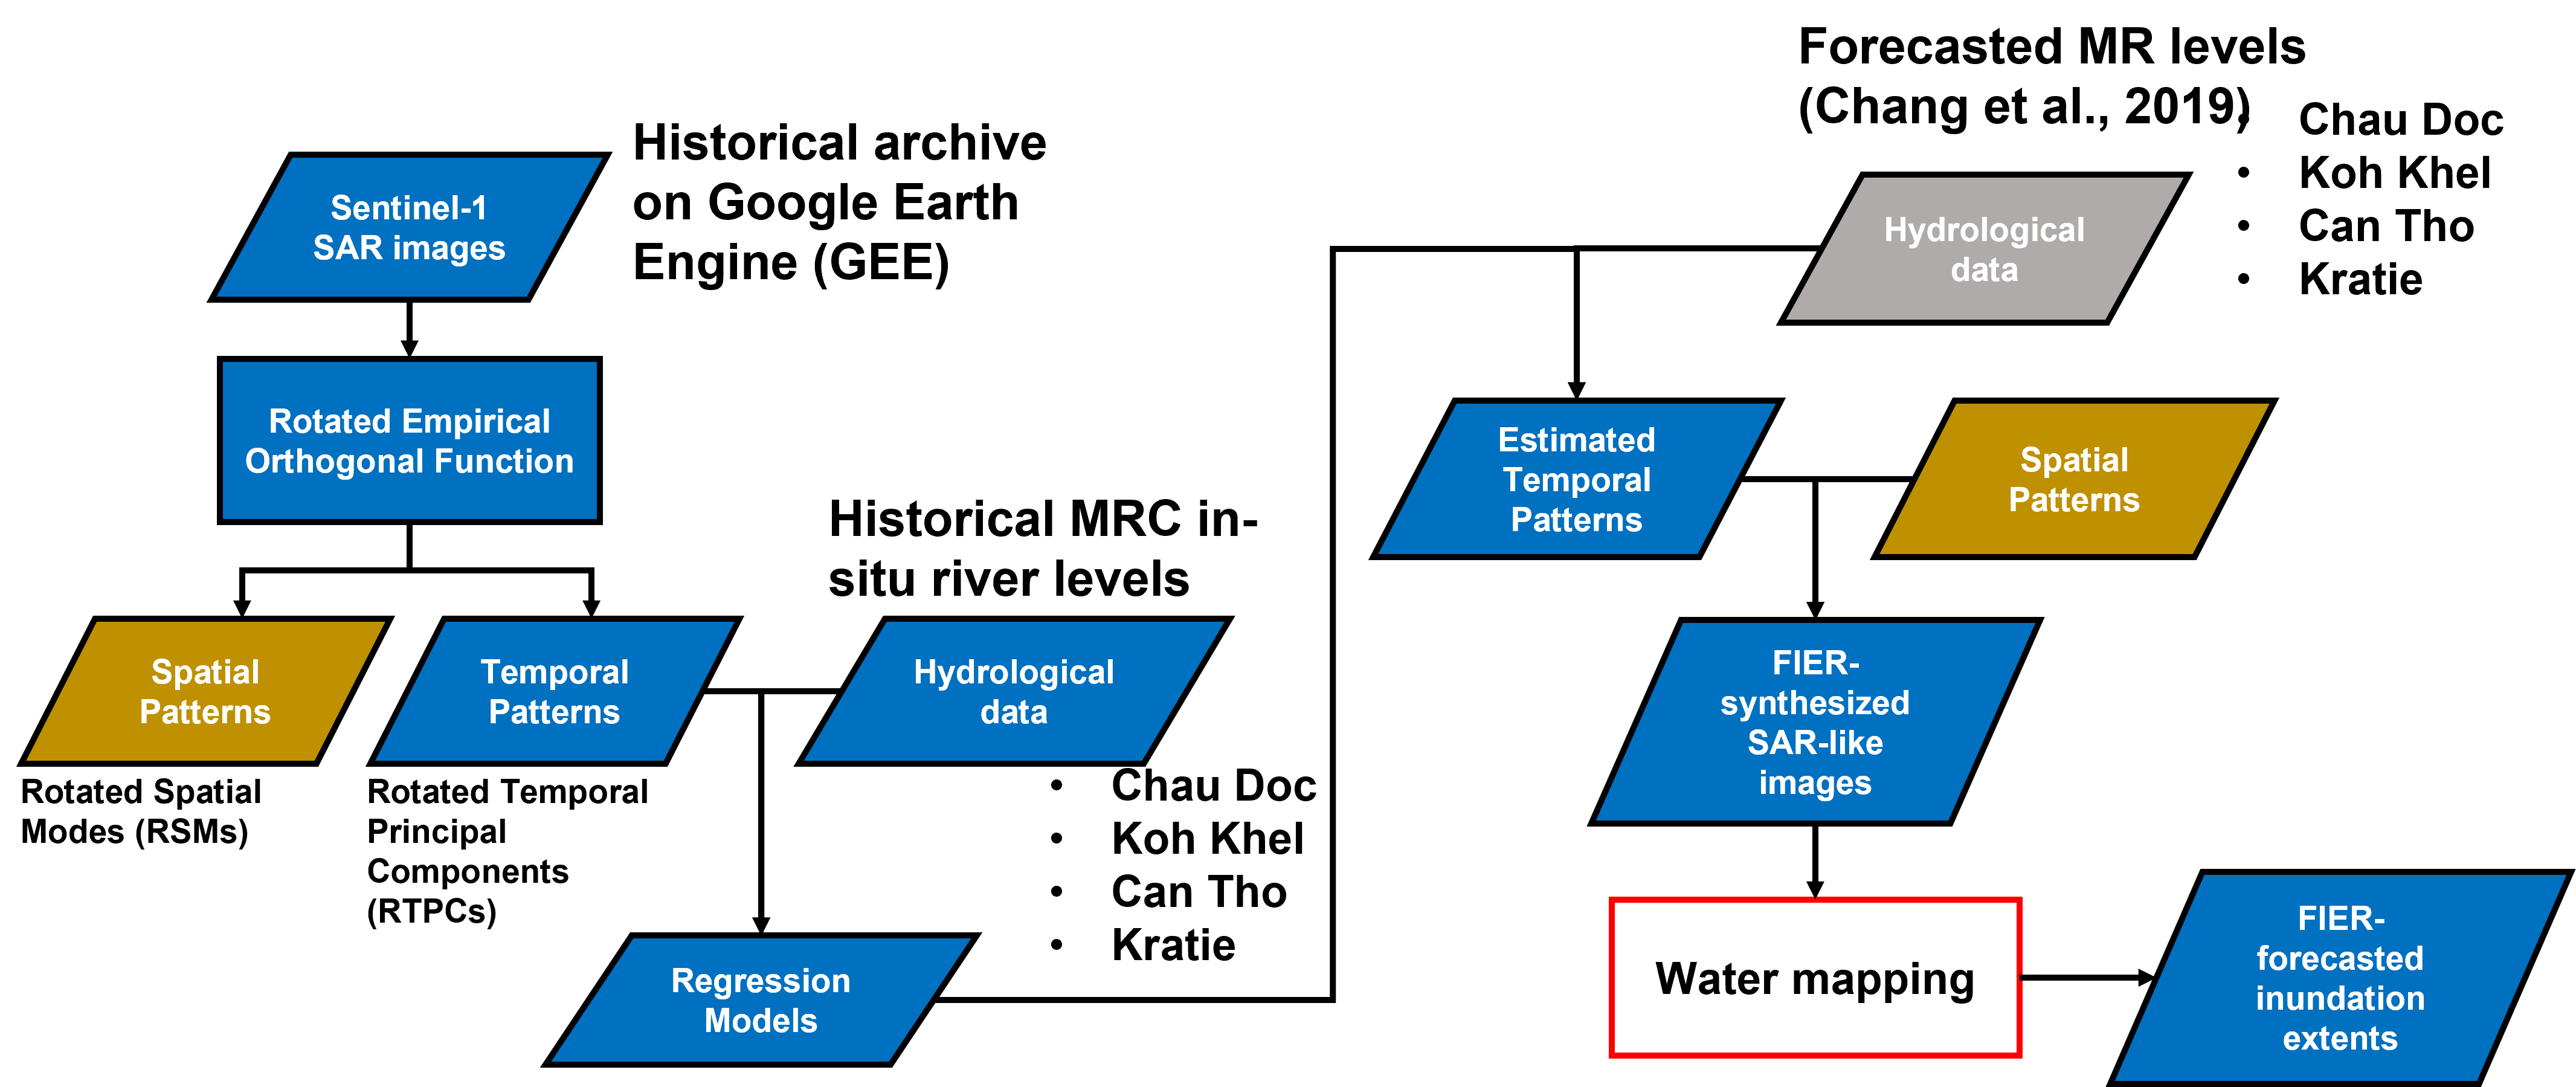

In [ ]:
def sig_eof_test(stack: xr.DataArray, option: int=1, monte_carlo_iter: int=5):

    """
    Significant test upon the EOF analysis results. The purpose is to find out the significant EOF modes
    to retain for rotation (REOF)

    args:
        stack (xr.DataArray): Input DataArray containing satellite imagery
        option (int): Type of significant test (1: Monte Carlo test; 2: North's rule-of-thumb)
        monte_carlo_iter (int): Iteration time for Monte Carlo test. Only applies when "option=1"

    output:
        sig_mode (int): number of mode to retain for the rotation of EOF analysis results

    """
    from sklearn.decomposition import PCA

    fontdict={
       'weight':'bold',
       'size':16
    }
    matplotlib.rc('font',**fontdict)

    time_size = stack.sizes['time']
    lat_size = stack.sizes['lat']
    lon_size = stack.sizes['lon']
    space_size = lat_size*lon_size

    temporal_mean = np.nanmean(stack.values, axis=0)

    flat_da = stack.values.reshape((time_size, space_size))
    aoi_mask_flat = ~(np.isnan(flat_da).all(axis=0))
    flat_da = flat_da[:, aoi_mask_flat]
    flat_da = flat_da - flat_da.mean(axis=0, keepdims=True)

    # ----- Record the original index of each pixels inside the AOI to recover the flattened data back to geographical dimension -----
    flat2geo = np.arange(np.prod(space_size))[aoi_mask_flat].reshape(1,-1)

    # ----- sklearn PCA (Eigenvalue of real data) -----
    pca = PCA(n_components=time_size)
    pcs = pca.fit_transform(flat_da)
    real_lamb = pca.explained_variance_

    if option==1:

        mc_lamb = np.full((time_size,monte_carlo_iter),np.nan)

        # ----- Monte Carlo simulation -----
        for i in range(monte_carlo_iter):

            # ----- Randomize observation (spatially shuffle the data) -----
            rng = np.random.default_rng()
            obs_temp = rng.permuted(flat_da, axis=1)

            pca = PCA(n_components=time_size)
            pcs = pca.fit_transform(obs_temp)
            eigv = pca.explained_variance_
            mc_lamb[:,i] = eigv

        mc_lamb = np.transpose(mc_lamb)
        mean_mc_lamb = np.mean(mc_lamb,axis=0)
        std_mc_lamb = np.std(mc_lamb,axis=0)

        plt.title('Scree Plot',fontdict=fontdict)
        plt.plot(np.arange(time_size)+1, real_lamb, marker='+')
        plt.errorbar(np.arange(time_size)+1, mean_mc_lamb, std_mc_lamb, capsize=1, marker='o', markersize=3)
        plt.legend(['From real data','From MonteCarlo sim.'])
        plt.xlabel('Mode',fontdict=fontdict)
        plt.ylabel('Eigenvalue',fontdict=fontdict)
        plt.show()

        sig_bool = real_lamb > mean_mc_lamb
        sig_mode = (np.argwhere(sig_bool==False)[0])[0]

    elif option==2:
        lamb_err = real_lamb*np.sqrt(2/time_size)
        lower_lamb = real_lamb - lamb_err
        upper_lamb = real_lamb + lamb_err

        real_lamb_temp = real_lamb.copy()

        sig_bool = lower_lamb[:-1] > upper_lamb[1:]
        sig_mode = (np.argwhere(sig_bool==False)[0])[0]

        plt.figure(figsize=(6,5))
        plt.errorbar(np.arange(len(real_lamb))+1, real_lamb, yerr=lamb_err, capsize=5, marker='o', markersize=3)
        plt.plot([sig_mode, sig_mode], [np.max(upper_lamb), np.min(lower_lamb)], color='r')
        plt.ylabel('Eigenvalue', fontdict=fontdict)
        plt.xlabel('Mode', fontdict=fontdict)
        plt.show()

    return sig_mode

In [ ]:
def reof(stack: xr.DataArray, n_modes: int=4):
    """
    Perform Rotated Empirical Orthogonal Function (REOF) on multi-temporal satellite images

    args:
        stack (xr.DataArray): DataArray of spatial temporal values with coord order of (t,y,x)
        n_modes (int): number of eof modes to use. default = 4

    returns:
        reof_ds (xr.Dataset): Dataset of REOF results with spatial modes, temporal modes, mean of data, and
                    explained variances as variables
    """

    from sklearn.decomposition import PCA


    def _ortho_rotation(components, method="varimax", tol=1e-6, max_iter=100):
        """Return rotated components."""
        nrow, ncol = components.shape
        rotation_matrix = np.eye(ncol)
        var = 0

        for _ in range(max_iter):
            comp_rot = np.dot(components, rotation_matrix)
            if method == "varimax":
                tmp = comp_rot * np.transpose((comp_rot**2).sum(axis=0) / nrow)
            elif method == "quartimax":
                tmp = 0
            u, s, v = np.linalg.svd(np.dot(components.T, comp_rot**3 - tmp))
            rotation_matrix = np.dot(u, v)
            var_new = np.sum(s)
            if var != 0 and var_new < var * (1 + tol):
                break
            var = var_new

        return np.dot(components, rotation_matrix)


    time_size = stack.sizes['time']
    lat_size = stack.sizes['lat']
    lon_size = stack.sizes['lon']
    space_size = lat_size*lon_size

    temporal_mean = np.nanmean(stack.values, axis=0)

    flat_da = stack.values.reshape((time_size, space_size))
    aoi_mask_flat = ~(np.isnan(flat_da).all(axis=0))
    flat_da = flat_da[:, aoi_mask_flat]
    flat_da = flat_da - flat_da.mean(axis=0, keepdims=True)

    # ----- Record the original index of each pixels inside the AOI to recover the flattened data back to geographical dimension -----
    flat2geo = np.arange(np.prod(space_size))[aoi_mask_flat].reshape(1,-1)

    # ----- sklearn PCA -----
    pca = PCA(n_components=n_modes)
    pcs = pca.fit_transform(flat_da)
    pcs = pcs.T
    S = pca.explained_variance_
    expvar  = pca.explained_variance_ratio_
    eofs = (pca.components_).T

    rotated_eofs = _ortho_rotation(eofs)

    # project the original time series data on the rotated eofs
    rotated_pcs = np.dot(flat_da, rotated_eofs)

    # get variance of each rotated mode
    rotated_var = np.var(rotated_pcs, axis=0)

    # get cumulative variance of all rotated modes
    total_rotated_var = rotated_var.cumsum()[-1]

    # get variance fraction of each rotated mode
    rotated_var_frac = ((rotated_var/total_rotated_var)*np.sum(expvar))

    # ----- Recover the flattened, AOI-only EOF array back to the geographical dimension -----
    rotated_eofs = rotated_eofs.T
    rotated_pcs = rotated_pcs.T

    sort_rotated_var_frac = np.argsort(-1*rotated_var_frac) # Index of explained variance in the descending order
    rotated_var_frac = rotated_var_frac[sort_rotated_var_frac]

    # sort modes based on variance fraction of REOF
    indx_rotated_var_frac_sort = np.expand_dims(sort_rotated_var_frac.data, axis=-1) # Mode X 1
    rotated_pcs = np.take_along_axis(rotated_pcs,indx_rotated_var_frac_sort,axis=0)

    rotated_eofs = np.take_along_axis(rotated_eofs,indx_rotated_var_frac_sort,axis=0)
    fill_eofs = np.ones((n_modes, space_size))*np.nan
    for ct_c in np.arange((rotated_eofs.shape[1])):
        fill_eofs[:,flat2geo[0,ct_c]] = rotated_eofs[:,ct_c]
    rec_eofs_img = fill_eofs.reshape(n_modes, lat_size, lon_size)

    # define data with variable attributes
    data_vars = {'spatial_modes':(['mode','lat','lon'], rec_eofs_img),
                 'temporal_modes':(['mode','time'], rotated_pcs),
                 'temporal_mean':(['lat','lon'], temporal_mean),
                 'explained_var':(['mode'], rotated_var_frac)
                }

    # define coordinates
    coords = {'time': (['time'], stack.time.values),
              'lat': (['lat'], stack.lat.values,{'units':'degrees North'}),
              'lon': (['lon'], stack.lon.values,{'units':'degrees East'}),
              'mode': (['mode'], np.arange(n_modes)+1)
             }


    # create dataset
    reof_ds = xr.Dataset(
        data_vars=data_vars,
        coords=coords,
    )

    return reof_ds





In [ ]:
def match_dates(original: xr.DataArray, matching: xr.DataArray) -> xr.DataArray:
    """Helper function to filter a DataArray from that match the data values of another.
    Expects that each xarray object has a dimesion named 'time'

    args:
        original (xr.DataArray): original DataArray with time dimension to select from
        matching (xr.DataArray): DataArray with time dimension to compare against

    returns:
        xr.DataArray: DataArray with values that have been temporally matched
    """

    # return the DataArray with only rows that match dates
    return original.where(original.time.isin(matching.time),drop=True)

In [ ]:
def find_hydro_mode(eof_stack: xr.Dataset, hydro_stack: xr.DataArray, r_thrd: float=0.5) -> xr.Dataset:
    """
    Calculate correlation between temporal patterns and hydrological data.
    This helps determine water-related mode. By default,  >=0.5 is considered to be correlated.

    args:
       eof_stack: Dataset with EOF or REOF results
       hydro_stack: DataArray with hydrological data
       r_thrd: Threshold (default: 0.5) of correlation coefficient to decide which modes are water-related

    output (site X modes):
       site: Names of selected sites of the modes
       best_r: The highest correlations between RTPCs and hydrological data
       best_p: Corresponding p-values of best_r
    """
    # get number of mode
    mode_num = eof_stack.sizes['mode']
    # get number of hydrological data sites
    site_num = hydro_stack.sizes['site']

    r = np.zeros((site_num, mode_num))
    p = np.zeros((site_num, mode_num))

    time_tpc = eof_stack.temporal_modes.sel(mode=int(1)).time
    time_hydro = hydro_stack[0].time
    comm_indx_hydro = time_hydro.isin(time_tpc)
    comm_indx_tpc = time_tpc.isin(hydro_stack[:,comm_indx_hydro.values].time)
    #print(hydro_stack[:,comm_indx_hydro.values].time.values)
    hydro_site = hydro_stack.site.values
    hydro_stack = hydro_stack[:,comm_indx_hydro.values].values


    n = hydro_stack.shape[-1]
    p_dist = stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)

    # ----- Instead of using FOR, see if it is possible to vectorize the process -----
    for ct_mode in range(mode_num):
        # get mode of tpc
        tpc = eof_stack.temporal_modes.sel(mode=int(ct_mode+1))[comm_indx_tpc]
        tpc = tpc.expand_dims(dim='site',axis=0).values.reshape(1,-1)

        r_da = np.concatenate((tpc, hydro_stack), axis=0)
        r_mode = np.expand_dims((pd.DataFrame(np.transpose(r_da)).corr(method='pearson').values[1:,0]), axis=1)
        p_mode = 2*p_dist.cdf(-abs(r_mode))

        if ct_mode==0:
            r = r_mode
            p = p_mode
        else:
            r = np.concatenate((r,r_mode), axis=1)
            p = np.concatenate((p,p_mode), axis=1)

    indx_max_r_site = np.nanargmax(np.abs(r), axis=0)
    r_temp = r[( indx_max_r_site, list(range(mode_num)) )]
    p_temp = p[( indx_max_r_site, list(range(mode_num)) )]

    indx_p_sig = p_temp <= 0.05
    indx_r_sig = np.abs(r_temp) >= r_thrd
    mode_out = ((np.logical_and(np.abs(r_temp) >= r_thrd, p_temp <= 0.05).astype(int)).nonzero())[0]

    site_out = indx_max_r_site[mode_out]
    r_out = r_temp[mode_out]
    p_out = p_temp[mode_out]

    tpc_hydro_r = xr.Dataset(

        data_vars=dict(
            site=(["mode"], hydro_site[site_out]),
            best_r=(["mode"], r_out),
            best_p=(["mode"], p_out)
        ),

        coords=dict(
            mode=(["mode"], eof_stack.mode.values[mode_out]),
        ),

    )

    return tpc_hydro_r


In [ ]:
# ----- Function to plot spatiotemporal patterns that have good correlation with hydrological data -----
def ts_sc_plot(eof_stack:xr.Dataset, hydro_stack:xr.DataArray, tpc_hydro_r_stack:xr.DataArray): #, reaches:list, indx_site:np.ndarray, indx_mode:np.ndarray, r_hydro_tpc:np.ndarray, out_folder:str):

    """
        This function generates and saves the plots of spatiotemporal patterns that are highly correlated with hydrological data

        arg:
            1. eof_stack: eof / reof results
            2. hydro_stack: hydrological data
            3. reaches: list of gauges / reaches of hydrologicla data used
            4. indx_site: indices of gauges in the list whose hydrologicla data are highly correlated with TPC / RTPC
            5. r_hydro_tpc: correlation between tpc / rtpc and hydrological data
            6. out_folder: output folder where plots are saved

    """

    #try:
    #    os.makedirs(out_folder+'/RTPC')
    #except:
    #    print('Folder exists: /'+out_folder+'/RTPC')
    #try:
    #    os.makedirs(out_folder+'/RSM')
    #except:
    #    print('Folder exists: /'+out_folder+'/RSM')


    plt.set_loglevel('WARNING')

    # ----- Time series plot -----
    #if len(indx_mode)==1:
    for ct_mode in np.arange(tpc_hydro_r_stack.sizes['mode']):
        mode = tpc_hydro_r_stack.mode[ct_mode].values
        site = tpc_hydro_r_stack.site[ct_mode].values
        high_r = tpc_hydro_r_stack.best_r[ct_mode].values
        tpc = eof_stack.temporal_modes.sel(mode=int(mode))
        sm = eof_stack.spatial_modes.sel(mode=int(mode)).values
        hydro_site = hydro_stack.sel(site=site).dropna(dim='time')

        good_hydro = match_dates(hydro_site, tpc)
        good_tpc = match_dates(tpc, good_hydro)

        if high_r < 0:
            good_tpc = good_tpc*-1
            sm = sm*-1

        good_time = good_tpc.time
        data_len = len(good_time)
        time_intv = int(data_len/10)
        time_list = [*range(0,data_len,time_intv)]

        # ----- Plot -----
        plt.figure(figsize=(5,5))
        plt.plot(good_time.values, stats.zscore(good_tpc), marker='+')
        plt.plot(good_time.values, stats.zscore(good_hydro), marker='+')
        plt.xticks(time_list, good_time[time_list].values, rotation=45, ha='right')
        plt.xlabel('Time', fontdict=fontdict)
        plt.ylabel('Normalized value', fontdict=fontdict)
        plt.legend(['RTPC-'+str(mode).zfill(2),str(site)])
        #plt.savefig(out_folder+'/RTPC/site-'+str(site)+'_tpc'+str(mode).zfill(2)+'.png', dpi=300, bbox_inches='tight')
        plt.show()


        # ----- Scatter -----
        #plt.scatter(good_hydro, good_tpc)
        #plt.xlabel(str(site), fontdict=fontdict)
        #plt.ylabel('RTPC-'+str(mode).zfill(2),fontdict=fontdict)
        #plt.show()

        # ----- Spatial modes -----
        #plt.figure(figsize=(10,10))
        plt.imshow(sm, cmap='jet', vmin=np.nanmin(sm)/1.5, vmax=-1*np.nanmin(sm)/1.5, interpolation='None') #, vmin=np.nanmin(sm), vmax=np.nanmax(sm))
        plt.colorbar()
        plt.title('RSM-'+str(mode).zfill(2),fontdict=fontdict)
        plt.xticks(lon_indx_list, lon_list, rotation=45)
        plt.yticks(lat_indx_list, lat_list)
        #plt.savefig(out_folder+'/RSM/sm-'+str(mode).zfill(2)+'.png', dpi=300, bbox_inches='tight')
        plt.show()

        # -- Output spatial modes as GeoTIFF --
        #sm = sm.rename({'lon':'x', 'lat':'y'})
        #sm = sm.rio.set_crs(4326)
        #sm.rio.to_raster(out_folder+'/RSM/sm-'+str(mode+1).zfill(2)+'.tif')

**REOF analysis**

1.  Significant test to see how many modes of spatiotemporal patterns should be retained
2.  REOF analysis which decomposes multi-temporal SAR images into spatiotemporal patterns


In [ ]:
# ----- Significant test -----
if not os.path.exists(root_output_folder+'/Day01/eof_result.nc'):
    sig_mode = sig_eof_test(img_stackVV.VV)
    print('Significant mode: First '+str(sig_mode).zfill(2)+' modes')

    # ----- REOF -----
    eof_result = reof(img_stackVV.VV, n_modes=sig_mode)
    eof_result.to_netcdf(root_output_folder+'/Day01/eof_result.nc')

    try:
        os.makedirs(root_output_folder+'/Day01/hydro2rtpc_mdl')
    except:
        print('Folder: '+root_output_folder+'/Day01/hydro2rtpc_mdl exists')
else:
    eof_result = xr.load_dataset(root_output_folder+'/Day01/eof_result.nc')

eof_result


In [ ]:
tpc_hydro_r  = find_hydro_mode(eof_result, hist_h_stack)
tpc_hydro_r.to_netcdf(root_output_folder+'/Day01/tpc_hydro_r.nc')

print(tpc_hydro_r.mode.values)
print(tpc_hydro_r.site.values)
print(tpc_hydro_r.best_r.values)

In [ ]:
# ----- Plot scatter plot and time-series plot -----
ts_sc_plot(eof_result, hist_h_stack, tpc_hydro_r)

**Neural network regression models**

Import the pre-trained neural network models and visualize them

In [ ]:
# ----- Model path -----
model_path = root_output_folder+'/Day01/hydro2rtpc_mdl/'
df_cv_results=pd.read_excel(model_path+'GridsearchCV_results.xlsx', index_col=0)

for ct_mode in np.arange(tpc_hydro_r.sizes['mode']):
    mode = tpc_hydro_r.mode[ct_mode].values
    site = tpc_hydro_r.site[ct_mode].values
    tpc = eof_result.temporal_modes.sel(mode=int(mode))
    hydro_site = hist_h_stack.sel(site=site).dropna(dim='time')

    comm_hydro = match_dates(hydro_site, tpc)
    comm_tpc = match_dates(tpc, comm_hydro)
    comm_time = comm_tpc.time
    comm_tpc = comm_tpc.values

    in_model = models.load_model(model_path+'site-'+str(site)+'_tpc'+str(mode).zfill(2)+'.h5')

    X = (comm_hydro.values.copy()).reshape(-1,1)
    Y = comm_tpc.reshape(-1,1)
    est_Y = in_model.predict(X, verbose=0)*df_cv_results.RTPC_std[ct_mode]+df_cv_results.RTPC_mean[ct_mode]
    R2 = metrics.r2_score(Y, est_Y)

    X_plt = np.linspace(np.amin(X), np.amax(X), X.size*10^10).reshape(-1, 1)
    est_Y_plt = in_model.predict(X_plt, verbose=0)*df_cv_results.RTPC_std[ct_mode]+df_cv_results.RTPC_mean[ct_mode]

    plt.figure(figsize=(4,3))
    plt.scatter(X, Y, s=10)
    plt.plot(X_plt, est_Y_plt, linewidth=2, color='r')
    plt.xlabel(str(site)+' water level (m)', fontdict={'weight':'bold'})
    plt.ylabel('RTPC-'+str(mode).zfill(2), fontdict={'weight':'bold'})
    plt.legend(['Data','Model\n(R$^2$: {:.2f})'.format(R2)])
    plt.show()

# FIER synthesis of pseudo-forecasted SAR-like images

1. Get the forecasted water levels generated by our in-house **altimetry + VIC** river level forecasting system (Chang et al., 2019)


In [ ]:
fct_h_stack = xr.load_dataarray(root_output_folder+'/Day01/hydrodata/forecast_h.nc').sel(site=tpc_hydro_r.site.values)

In [ ]:
fct_h_stack

2.  Define **a date of interest (DOI)** and a **lead time (day)** then put the forecasted hydrological data into the fitted regression models to forecast SAR temporal patterns
3.  Combine forecasted SAR temporal patterns with spatial patterns to synthesize pseudo-forecasted SAR-like images

In [ ]:
# Example dates with observed Sentinel-1A images

# '2022-10-13', '2022-10-25', '2022-11-06', '2022-11-18', '2022-11-30'


# ---------------
doi = '2022-10-13'
lead_time = 1 # 1 to 18 (days)
forecast_opt = 1

eof_result = xr.load_dataset(root_output_folder+'/Day01/eof_result.nc')
df_cv_results=pd.read_excel(model_path+'/GridsearchCV_results.xlsx', index_col=0)


all_meanVV = eof_result.temporal_mean
for ct_mode in np.arange(eof_result.sizes['mode']):

    mode = tpc_hydro_r.mode[ct_mode].values
    site = tpc_hydro_r.site[ct_mode].values

    sm = eof_result.spatial_modes.sel(mode=int(mode))
    if forecast_opt:
        hydro_site = fct_h_stack.sel(site=site).sel(time=doi).sel(lead_time=lead_time)
        #print(hydro_site.values)
    else:
        hydro_site = hist_h_stack.sel(site=site).sel(time=doi)
        #print(hydro_site.values)

    in_model = models.load_model(model_path+'/site-'+str(site)+'_tpc'+str(mode).zfill(2)+'.h5')

    tf_hydro = hydro_site.values.reshape(-1,1)
    #tf_hydro = tf.data.Dataset.from_tensors(in_good_hydro)
    est_tpc = in_model.predict(tf_hydro, verbose=0)*df_cv_results['RTPC_std'][ct_mode]+df_cv_results['RTPC_mean'][ct_mode]

    est_tpc1 = np.tile(est_tpc[:, :, None], (1, sm.sizes['lat'], sm.sizes['lon']))
    sm1 = np.tile(sm.values[None,:,:], (est_tpc.shape[0], 1, 1))

    syn_sar_temp = sm1*est_tpc1
    if ct_mode==0:
        syn_sar = syn_sar_temp
    else:
        syn_sar = syn_sar + syn_sar_temp

syn_sar = syn_sar + all_meanVV.values
syn_sar = xr.DataArray(

    data = syn_sar,
    coords=dict(
        time=(["time"], np.asarray([doi])),
        lat=(["lat"], sm.lat.values),
        lon=(["lon"], sm.lon.values)

    )
)
syn_sar.name = 'intensity'



**Visualize FIER-synthesized SAR-like image**

In [ ]:
plt.imshow(syn_sar[0], interpolation='none', vmin=-20, vmax=0, cmap='gray')
plt.title(doi,fontdict=fontdict)
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
if forecast_opt:
    plt.title('SAR intensity (dB)\n'+doi+'\n'+str(lead_time).zfill(2)+'-day lead time',fontdict=fontdict)
else:
    plt.title('SAR intensity (dB)\n'+doi,fontdict=fontdict)
plt.colorbar()
plt.show()

#Z-Score water segmentation on FIER synthesized map

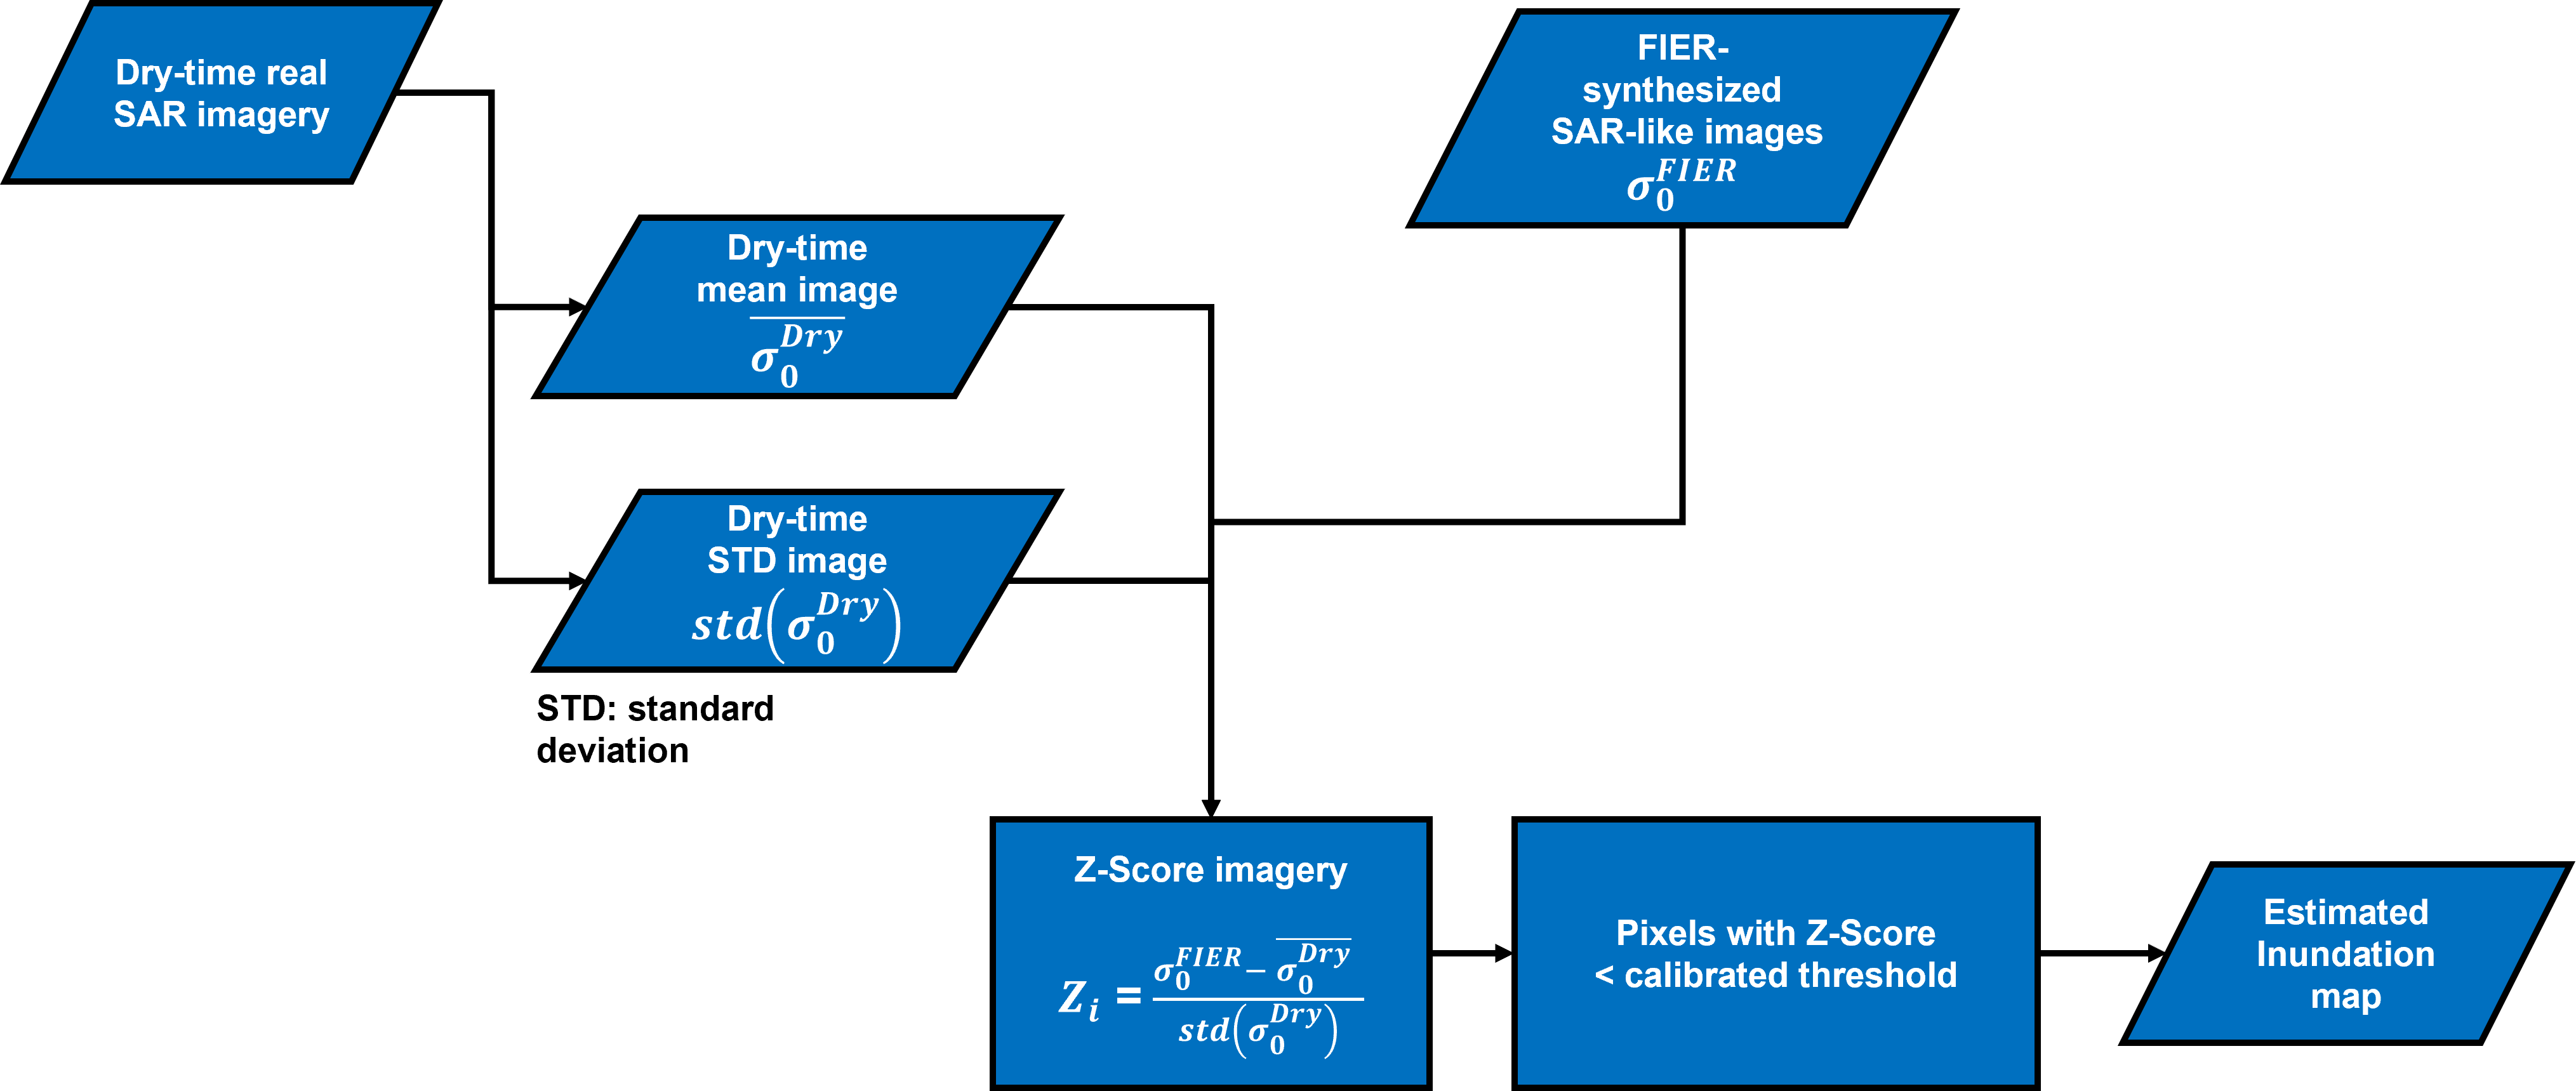

1.  Statistics images of real SAR images are needed
  - Dry-time mean, Dry-time STD
  - All-time mean


In [ ]:
# ----- Calculate statistics image as references for water segmentation -----
# -- Real dry-time mean and STD --
dry_mon = np.array([2,4,5,6]) # The dry months based on historical monthly average water levels at the selected gauges
mon_array = pd.DatetimeIndex([pd.to_datetime(date_str).strftime('%Y-%m-%d') for date_str in img_stackVV.time.values]).month

dry_mon_indx = np.isin(mon_array, dry_mon)
dry_meanVV = np.nanmean( img_stackVV.VV[dry_mon_indx, :, :], axis=0 )
dry_stdVV = np.nanstd( img_stackVV.VV[dry_mon_indx, :, :], axis=0 )

In [ ]:
plt.imshow(dry_stdVV, cmap='jet', vmin=0, vmax=3, interpolation='none')
plt.title('Dry-time STD [VV]',fontdict=fontdict)
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
plt.colorbar()
plt.show()

2.  Generate Z-Score image
3.  Water classification on Z-Score image using pre-defined threshold

In [ ]:
if forecast_opt:
    hydro_sites = fct_h_stack.sel(site=tpc_hydro_r.site.values).sel(time=doi).sel(lead_time=lead_time).values.reshape(1,-1)
else:
    hydro_sites = hist_h_stack.sel(site=tpc_hydro_r.site.values).sel(time=doi).values.reshape(1,-1)


# -- load the z-score threshold model from G-Drive --
loaded_model = joblib.load('/content/drive/MyDrive/FIER_Training_July2023/Day02/h2zscore_svm_model.sav')
zscore_threshold = loaded_model.predict(hydro_sites)
print('calibrated Z-score threshold:', zscore_threshold[0])

# -- Generate Z-Score image --
z_score_img = (syn_sar[0]-dry_meanVV)/dry_stdVV


# -- Plot Z-Score image --
plt.imshow(z_score_img, cmap='jet', vmin=-3, vmax=3,interpolation='None')
plt.colorbar()
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
plt.title('Z-Score: '+doi,fontdict=fontdict)
if forecast_opt:
    plt.title('FIER Z-Score\n'+doi+'\n'+str(lead_time).zfill(2)+'-day lead time',fontdict=fontdict)
else:
    plt.title('FIER Z-Score\n'+doi,fontdict=fontdict)
plt.show()

# -- Generate water map --
aoi_indx = np.argwhere( ~np.isnan(img_stackVV.VV.values[0]) )
water_indx = np.argwhere( z_score_img.values < zscore_threshold )

water_map = np.empty((syn_sar.sizes['lat'], syn_sar.sizes['lon']))
water_map[:] = nan
water_map = np.where(~np.isnan(img_stackVV.VV.values[0]), 0, water_map)
water_map = np.where(z_score_img.values < zscore_threshold, 1, water_map)
water_map = np.where(pwater_mask.values==1, 1, water_map)

## -- Export water map to G-Drive as NetCDF to be used for water depth estimation --
#water_map_da = xr.Dataset(
#    data_vars = {"Inundation Map":(['lat','lon'], np.where(pwater_mask.values==1, 0, np.where(np.isnan(water_map),0,water_map)))},
#    coords={
#        "lat":(["lat"], sm.lat.values),
#        "lon":(["lon"], sm.lon.values)
#    }
#)
#if not os.path.exists('/content/drive/MyDrive/FIER_Training_2023/FIER_flood_maps/'):
#    os.makedirs('/content/drive/MyDrive/FIER_Training_2023/FIER_flood_maps/')
#water_map_da.to_netcdf('/content/drive/MyDrive/FIER_Training_2023/FIER_flood_maps/'+doi+'_lt'+str(lead_time).zfill(2)+'.nc')


# -- Visualize water map --
#try:
#    os.makedirs(root_output_folder+'/water_map')
#except:
#    print('Folder: '+root_output_folder+'/water_map already exists')
water_cmap =  matplotlib.colors.ListedColormap(["silver","darkblue"])
plt.imshow(water_map, cmap=water_cmap, interpolation='None')
plt.clim(vmin=-0.5, vmax=1.5)
cbar = plt.colorbar(ticks=[0,1])
c_ticklabels = ['Non-water','Water']
cbar.set_ticklabels(c_ticklabels, rotation=90, va='center')
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
if forecast_opt:
    plt.title('FIER water map\n'+doi+'\n'+str(lead_time).zfill(2)+'-day lead time',fontdict=fontdict)
else:
    plt.title('FIER water map\n'+doi,fontdict=fontdict)
#plt.savefig(root_output_folder+'/water_map/poly'+doi+'.png', dpi=300, bbox_inches='tight')
plt.show()



# Z-Score water segmentation on real SAR imagery

1.  Get real SAR image acquired on the date of interest from GEE and conduct pre-processing
2.  Use RESTEE to convert it to Python-supportive dataset

**( We have prepared the data needed )**

In [ ]:
run_restee = 0
if not run_restee:
    img_stack_cmpVV = xr.load_dataarray(root_output_folder+'/Day02/real_SAR_images/'+doi+'_VV.nc')

if run_restee:

    end_doi = ee.Date(doi).advance(1,'day').format('Y-M-d').getInfo()

    # ----- Get the Sentinel-1 SAR ImageCollection from GEE for cross-comparison purpose -----
    S1_ImgCol_cmp = (
        ee.ImageCollection('COPERNICUS/S1_GRD')
        #.filterBounds(aoi)
        .filter(ee.Filter.date(doi,end_doi))
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
        .filter(ee.Filter.eq('relativeOrbitNumber_start',26))
        .filter(ee.Filter.eq('relativeOrbitNumber_stop',26))
        .filter(ee.Filter.eq('instrumentMode', 'IW'))
        .filter(ee.Filter.eq('platform_number', 'A'))
        .filter(ee.Filter.eq('orbitProperties_pass','ASCENDING'))
        .filter(ee.Filter.And(ee.Filter.gte('sliceNumber',1), ee.Filter.lte('sliceNumber',4)))
    )

    hf_S1_ImgCol_cmp = hf.datasets.Dataset.from_imgcollection(S1_ImgCol_cmp)

    hf_S1_ImgCol_cmp = hf_S1_ImgCol_cmp.aggregate_time(clip_to_area=True)
    S1_ImgCol_flt_msc_cmp = hf_S1_ImgCol_cmp.apply_func(hf.slope_correction, elevation=ee.Image("MERIT/DEM/v1_0_3").select("dem"))
    S1_ImgCol_flt_msc_filt_cmp = S1_ImgCol_flt_msc_cmp.apply_func(hf.filtering.gamma_map)
    S1_ImgCol_proc_cmpVV = ee.ImageCollection(S1_ImgCol_flt_msc_filt_cmp.collection.select('VV').map(img_col_clip))


    # ----- RESTEE process -----
    # Since running RESTEE can take time depending on data size, for the initial run, data will be exported as NetCDF for the use of later process --

    # -- Define spatial resolution (unit: degree) --
    res = 0.005
    res_str = str(int(100000*res)).zfill(3)

    # ----- Create a session -----
    # -- Provide Google Cloud ProjectID and the path to the credential --
    PROJECT_ID= 'restee-training'
    CREDENTIAL='/content/drive/MyDrive/FIER_Training_2023/credential/restee-training-4602aa9eb906.json' # Make sure to change it to your own credential
    session=restee.EESession(PROJECT_ID, CREDENTIAL)

    # ----- Define the domain -----
    domain = restee.Domain.from_ee_geometry(session, aoi, resolution=res)

    # -- RESTEE converts GEE ImageCollection as XARRAY dataset --
    init_img_stack_cmpVV = restee.imgcollection_to_xarray(session, domain, S1_ImgCol_proc_cmpVV ,bands=['VV'])

    init_img_stack_cmpVV = init_img_stack_cmpVV.sortby("time")
    init_img_stack_cmpVV["time"] = init_img_stack_cmpVV["time"].dt.strftime("%Y-%m-%d")

    # ----- Make pixels out of image frame as NaN -----
    init_img_stack_cmpVV = init_img_stack_cmpVV.where(init_img_stack_cmpVV['VV']!=0)

    # -- Make sure each pixel location consistently has data over time, otherwise set it as NaN --
    img_stack_mean_cmpVV = init_img_stack_cmpVV.mean(dim='time', skipna=False, keep_attrs=True)
    indx_img_stack_null_cmpVV = img_stack_mean_cmpVV.isnull(keep_attrs=True)
    img_stack_cmpVV = init_img_stack_cmpVV.where(~indx_img_stack_null_cmpVV['VV'])
    img_stack_cmpVV = img_stack_cmpVV.where(~pwater_mask).drop('time').squeeze().VV

    if not os.path.exists(root_output_folder+'/Day02/real_SAR_images'):
        os.makedirs(root_output_folder+'/Day02/real_SAR_images')
    img_stack_cmpVV.to_netcdf(root_output_folder+'/Day02/real_SAR_images/'+doi+'_VV.nc')



In [ ]:
plt.imshow(img_stack_cmpVV, cmap='gray', vmin=-20, vmax=0, interpolation='None')
plt.title('Real SAR [VV]: '+doi, fontdict=fontdict)
plt.colorbar()
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
plt.show()

4.  Generate Z-Score images and then perform water-classification to get water map

In [ ]:
z_score_img_cmpVV = (img_stack_cmpVV-dry_meanVV)/dry_stdVV

# -- Plot Z-Score image --
plt.imshow(z_score_img_cmpVV, cmap='jet', vmin=-3, vmax=3,interpolation='None')
plt.colorbar()
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
plt.title('Real Z-Score:\n'+doi,fontdict=fontdict)
plt.show()

# -- Generate water map --
water_map_cmp = np.empty((syn_sar.sizes['lat'], syn_sar.sizes['lon']))
water_map_cmp[:] = nan
water_map_cmp = np.where(~np.isnan(img_stack_cmpVV), 0, water_map_cmp)
water_map_cmp = np.where(z_score_img_cmpVV < -3, 1, water_map_cmp)
water_map_cmp = np.where(pwater_mask.values==1, 1, water_map_cmp)

plt.imshow(water_map_cmp, cmap=water_cmap, interpolation='None')
plt.clim(vmin=-0.5, vmax=1.5)
cbar = plt.colorbar(ticks=[0,1])
c_ticklabels = ['Non-water','Water']
cbar.set_ticklabels(c_ticklabels, rotation=90, va='center')
plt.title('Real SAR water map:\n'+doi, fontdict=fontdict)
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
#plt.savefig(root_output_folder+'/water_map/real'+doi+'.png', dpi=300, bbox_inches='tight')
plt.show()

#Cross-comparison: FIER-synthesized to the real one

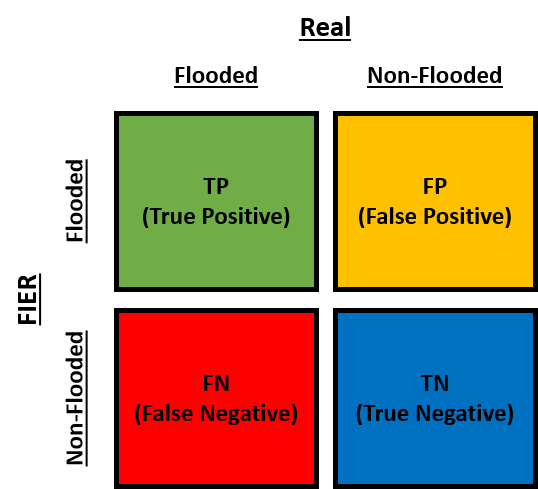

1. Overall accuracy
2. Cohen's Kappa (Cohen, 1960)

   Interpretation (Landis and Koch, 1977):
   - 0.21 to 0.40  Fair
   - 0.41 to 0.60  Moderate
   - 0.61 to 0.80  Substantial
   - 0.81 to 1.00  Perfect

3. Critical Success Index
   
   Interpretation (Bernhofen et al., 2018)
   - 0.00 to 0.50  Poor
   - 0.70 to 1.00  Good

In [ ]:
# ----- Get difference bewteen flood maps -----
dif_map = water_map - water_map_cmp

total_pix = np.count_nonzero(~np.isnan(dif_map))
tpn_pix = np.count_nonzero(dif_map==0)
with np.errstate(divide='ignore',invalid='ignore'):
    tp_indx = (dif_map / water_map)==0
    tp_pix = np.count_nonzero(tp_indx)
tn_pix = tpn_pix - tp_pix
fp_pix = np.count_nonzero(dif_map==1)
fn_pix = np.count_nonzero(dif_map==-1)

cmp_map = np.empty((syn_sar.sizes['lat'], syn_sar.sizes['lon']))
cmp_map[:]=nan
cmp_map = np.where(~np.isnan(img_stackVV.VV.values[0]), 4, cmp_map)
cmp_map = np.where(tp_indx, 1, cmp_map)
cmp_map = np.where(dif_map==1, 2, cmp_map)
cmp_map = np.where(dif_map==-1, 3, cmp_map)


acc = tpn_pix*100/total_pix
ckp = 2*(tp_pix*tn_pix - fn_pix*fp_pix)*100 / ( (tp_pix+fp_pix)*(fp_pix+tn_pix)+(tp_pix+fn_pix)*(fn_pix+tn_pix) )
csi = (tp_pix)*100/(tp_pix+fp_pix+fn_pix)

cmp_clrmap =  matplotlib.colors.ListedColormap(["green","orange","red","blue"])
plt.imshow(cmp_map, cmap=cmp_clrmap, interpolation='None')
plt.clim(vmin=0.5,vmax=4.5)
cbar = plt.colorbar(ticks=[1,2,3,4])
c_ticklabels = ['TP', 'FP', 'FN', 'TN']
cbar.set_ticklabels(c_ticklabels)
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
if forecast_opt:
    plt.title('Cross-comparison\nFIER water map\n'+doi+'\n'+str(lead_time).zfill(2)+'-day lead time',fontdict=fontdict)
else:
    plt.title('Cross-comparison\nFIER water map\n'+doi,fontdict=fontdict)#plt.savefig(root_output_folder+'/cross_cmp/cmp_poly'+doi+'.png', dpi=300, bbox_inches='tight')
plt.show()


if forecast_opt:
    print('Lead time: {:2d}'.format(lead_time))
print('Accuracy: {:.2f}'.format( acc )+'%')
print("Cohen's Kappa: {:.2f}".format( ckp )+'%')
print('Critical Success Index: {:.2f}'.format( csi )+'%')

In [ ]:
plt.imshow(water_map_cmp, cmap=water_cmap, interpolation='None')
plt.clim(vmin=-0.5, vmax=1.5)
cbar = plt.colorbar(ticks=[0,1])
c_ticklabels = ['Non-water','Water']
cbar.set_ticklabels(c_ticklabels)
plt.title('Real SAR water map:\n'+doi, fontdict=fontdict)
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
#plt.savefig(root_output_folder+'/water_map/real'+doi+'.png', dpi=300, bbox_inches='tight')
plt.show()

plt.imshow(water_map, cmap=water_cmap, interpolation='None')
plt.clim(vmin=-0.5, vmax=1.5)
cbar = plt.colorbar(ticks=[0,1])
c_ticklabels = ['Non-water','Water']
cbar.set_ticklabels(c_ticklabels)
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
if forecast_opt:
    plt.title('FIER water map\n'+doi+'\n'+str(lead_time).zfill(2)+'-day lead time',fontdict=fontdict)
else:
    plt.title('FIER water map\n'+doi,fontdict=fontdict)
#plt.savefig(root_output_folder+'/water_map/poly'+doi+'.png', dpi=300, bbox_inches='tight')
plt.show()


#Acknowledgment

**-  FIER**
> Chang et al. (2020) (https://doi.org/10.1016/j.rse.2020.111732)

> Chang et al. (2023) (https://doi.org/10.1016/j.envsoft.2023.105643)


**-  HYDRAFloods: Kel et al. (https://servir-mekong.github.io/hydra-floods/)**

**-  RESTEE: Kel Markert (https://github.com/KMarkert/restee)**